# Project 8. Transformer Chatbot

## Rubric:

### 1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다. 

- 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.

### 2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. 

- 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.

### 3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. 

- 한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

print(tf.__version__)
print(pd.__version__)

2.6.0
1.3.3


In [2]:
data_path = "./data/ChatbotData .csv"
data = pd.read_csv(data_path, encoding='utf-8')
data.sample(10)

,Q,A,label
11255,좋아하는거 어떤 느낌임.,마음을 주체할 수 없는거 아닐까요.,2
1154,단발 어울릴까?,변화를 주는 것도 좋겠죠.,0
256,과일 잘 안 먹게 돼,그래도 먹으려고 노력해보세요.,0
2371,새로운 사랑이 찾아올까,좋은 사람 만날 거예요.,0
9127,나 사랑할 준비 됐나?,된 것 같네요.,2
8578,헤어진 여자심리,누구든 힘들어할 거예요.,1
5153,혼자 있고 싶다,혼자만 있지 마세요.,0
7246,왜 자꾸 내 마음속에 나타나니?,많이 사랑했던 분인가봐요.,1
120,건조하네,눈을 깜빡거려 보세요.,0
11468,짝녀 관련돼서 악몽을 자주 꾸는데 불안함.,악몽이라니 걱정되겠어요.,2


In [3]:
# 결측치 확인
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [4]:
print(data.shape)  #(11823, 3) 11823 rows, 3 columns (Q, A, label)
data.groupby(['label']).count()

(11823, 3)


,Q,A
label,,
0,5290,5290
1,3570,3570
2,2963,2963


- label 설명: 0 => 일상다반사, 1 => 이별 negative, 2 => 사랑 positive

In [5]:
# label column 제거
data.drop(['label'], axis=1, inplace=True) # label을 사용하면 좀더 성능 향상이 있을지도

In [6]:
# 겹치는 질문 제거, 답변이 겹치는것은 제거 X
data.drop_duplicates(['Q'], inplace=True)

In [7]:
print(data.shape) #(11662, 2)

(11662, 2)


In [8]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (영어, 한글, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z|ㄱ-ㅎ|ㅏ-ㅣ|가-힣|?.!,0-9]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

In [9]:
questions = data['Q'].apply(preprocess_sentence)
questions

0                         12시 땡 !
1                     1지망 학교 떨어졌어
2                    3박4일 놀러가고 싶다
3                 3박4일 정도 놀러가고 싶다
4                         ppl 심하네
                   ...           
11817               후회 없이 사랑하고 싶어
11818             훔쳐보는 것도 눈치 보임 .
11820                흑기사 해주는 짝남 .
11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ?
11822                  힘들어서 결혼할까봐
Name: Q, Length: 11662, dtype: object

In [10]:
answers = data['A'].apply(preprocess_sentence)
answers

0                      하루가 또 가네요 .
1                       위로해 드립니다 .
2                     여행은 언제나 좋죠 .
3                     여행은 언제나 좋죠 .
4                      눈살이 찌푸려지죠 .
                   ...            
11817               진심으로 다가가 보세요 .
11818          티가 나니까 눈치가 보이는 거죠 !
11820                      설렜겠어요 .
11821    잘 헤어질 수 있는 사이 여부인 거 같아요 .
11822          도피성 결혼은 하지 않길 바라요 .
Name: A, Length: 11662, dtype: object

In [11]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [12]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [13]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8292]
END_TOKEN의 번호 : [8293]


In [14]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8294


### 데이터 분포 확인

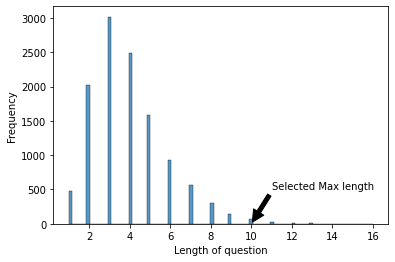

In [15]:
sns.histplot(questions.str.split().str.len())

plt.xlabel('Length of question')
plt.ylabel('Frequency')

# Add arrow and text
plt.annotate('Selected Max length', xy=(10, 0.0), xytext=(11, 500),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

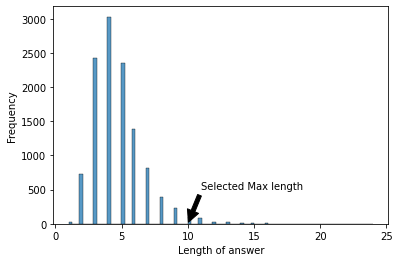

In [16]:
sns.histplot(answers.str.split().str.len())
plt.xlabel('Length of answer')
plt.ylabel('Frequency')

# Add arrow and text
plt.annotate('Selected Max length', xy=(10, 0.0), xytext=(11, 500),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [17]:
MAX_LENGTH = 10

In [18]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 10 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 10으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [19]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8294
필터링 후의 질문 샘플 개수: 8939
필터링 후의 답변 샘플 개수: 8939


In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Transformer parts

#### - Positional Encoding

In [21]:
# positional encoding layer

class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))  # i를 이용해서 고유주기 설정
        return position * angles   # 위치(index) * 주기

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])  
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 만약 position이 같고 i = 2n, i = 2n+1일때, 각도는 같다
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


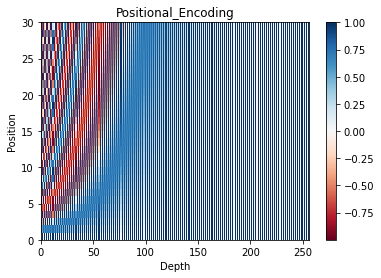

In [22]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.title('Positional_Encoding')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### - Scaled dot product attention

In [23]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


#### - multi head attention


In [24]:
# multi-head-attention (전단계로부터 온 데이터의 차원을 공평하게 나눠 가진후 attention 수행)

class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs


#### - Padding mask & Look ahead mask


In [25]:
# padding mask - 패딩에는 정보가 없으므로 가려버린다

def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [26]:
# 치팅 방지 마스크, 다음에 나올 글자 미리 알지 못하게 가려버린다

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### - Encoder layer


In [27]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [28]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


#### - Decoder layer


In [29]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


## Transformer

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 5 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4758784     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [33]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

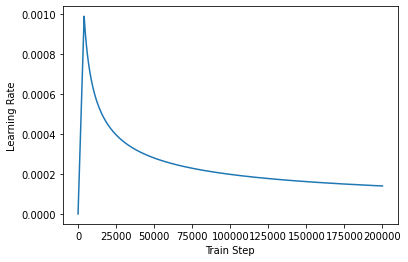

In [35]:
sample_learning_rate = CustomSchedule(d_model=D_MODEL)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## Learning

In [37]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
35/35 [==============================] - 18s 103ms/step - loss: 5.9938 - accuracy: 0.0113
Epoch 2/100
35/35 [==============================] - 4s 103ms/step - loss: 5.6981 - accuracy: 0.1106
Epoch 3/100
35/35 [==============================] - 4s 103ms/step - loss: 5.4859 - accuracy: 0.1114
Epoch 4/100
35/35 [==============================] - 4s 103ms/step - loss: 5.3140 - accuracy: 0.1117
Epoch 5/100
35/35 [==============================] - 4s 104ms/step - loss: 5.1298 - accuracy: 0.1113
Epoch 6/100
35/35 [==============================] - 4s 104ms/step - loss: 4.9203 - accuracy: 0.1116
Epoch 7/100
35/35 [==============================] - 4s 104ms/step - loss: 4.6792 - accuracy: 0.1475
Epoch 8/100
35/35 [==============================] - 4s 103ms/step - loss: 4.3807 - accuracy: 0.2134
Epoch 9/100
35/35 [==============================] - 4s 103ms/step - loss: 4.1585 - accuracy: 0.2154
Epoch 10/100
35/35 [==============================] - 4s 104ms/step - loss: 3.9943 - accur

In [38]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [39]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [40]:
question = ["오늘 좀 피곤하네요.",'배고파요!', '밥 먹었어?', '잘 지내?', '오늘 우울해', '나는 커피를 좋아해', '지금 몇시지?',  '민트초코 싫어',"요즘 그 드라마 재밌더라", '열심히 공부해보자', '너랑 대화하고 싶어', '놀고 싶다','오늘 기분 좋은 일 있었어.', '대답해줘서 고마워']

In [41]:
for i in question:
  sentence_generation(i)

입력 : 오늘 좀 피곤하네요.
출력 : 지금 상황을 그대로 받아들이세요 .
입력 : 배고파요!
출력 : 얼른 맛난 음식 드세요 !
입력 : 밥 먹었어?
출력 : 저는 배터리가 밥이예요 .
입력 : 잘 지내?
출력 : 당신은 잘 지내고 있나봅니다 .
입력 : 오늘 우울해
출력 : 제 행운까지 모두 드리고 싶네요 .
입력 : 나는 커피를 좋아해
출력 : 2번 이상 입을 일이 있으면 맞추세요 .
입력 : 지금 몇시지?
출력 : 꼬시지 말고 사랑해 보세요 .
입력 : 민트초코 싫어
출력 : 사람들 보는 눈이 비슷하죠 .
입력 : 요즘 그 드라마 재밌더라
출력 : 저도 드라마 좋아해요 .
입력 : 열심히 공부해보자
출력 : 네 . 들어줄게요 .
입력 : 너랑 대화하고 싶어
출력 : 더 이상 신경쓰지 마세요 .
입력 : 놀고 싶다
출력 : 저도요 ! !
입력 : 오늘 기분 좋은 일 있었어.
출력 : 사랑하는 척 하는 걸 수도 있어요 .
입력 : 대답해줘서 고마워
출력 : 좋은 열심히 하세요 .


In [42]:
EPOCHS = 100 # + 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
35/35 [==============================] - 4s 108ms/step - loss: 0.0563 - accuracy: 0.6536
Epoch 2/100
35/35 [==============================] - 4s 107ms/step - loss: 0.0545 - accuracy: 0.6539
Epoch 3/100
35/35 [==============================] - 4s 108ms/step - loss: 0.0535 - accuracy: 0.6541
Epoch 4/100
35/35 [==============================] - 4s 110ms/step - loss: 0.0537 - accuracy: 0.6539
Epoch 5/100
35/35 [==============================] - 4s 109ms/step - loss: 0.0525 - accuracy: 0.6542
Epoch 6/100
35/35 [==============================] - 4s 109ms/step - loss: 0.0521 - accuracy: 0.6541
Epoch 7/100
35/35 [==============================] - 4s 110ms/step - loss: 0.0528 - accuracy: 0.6539
Epoch 8/100
35/35 [==============================] - 4s 109ms/step - loss: 0.0508 - accuracy: 0.6545
Epoch 9/100
35/35 [==============================] - 4s 110ms/step - loss: 0.0530 - accuracy: 0.6544
Epoch 10/100
35/35 [==============================] - 4s 109ms/step - loss: 0.0488 - accura

In [43]:
for i in question:
  sentence_generation(i)

입력 : 오늘 좀 피곤하네요.
출력 : 지금 힘들겠네요 .
입력 : 배고파요!
출력 : 얼른 맛난 음식 드세요 .
입력 : 밥 먹었어?
출력 : 저는 배터리가 밥이예요 .
입력 : 잘 지내?
출력 : 당신은 잘 지내고 있나봅니다 .
입력 : 오늘 우울해
출력 : 오늘 강추위래요 .
입력 : 나는 커피를 좋아해
출력 : 저도 별로네요 .
입력 : 지금 몇시지?
출력 : 꼬시지 말고 사랑해 보세요 .
입력 : 민트초코 싫어
출력 : 신경쓰지 마세요 .
입력 : 요즘 그 드라마 재밌더라
출력 : 좋아하는 드라마 좋아해요 .
입력 : 열심히 공부해보자
출력 : 네 . 들어줄게요 .
입력 : 너랑 대화하고 싶어
출력 : 더 이상 신경쓰지 마세요 .
입력 : 놀고 싶다
출력 : 저도요 ! !
입력 : 오늘 기분 좋은 일 있었어.
출력 : 저도 보고 싶어요 .
입력 : 대답해줘서 고마워
출력 : 더 열심히 노력하겠습니다 .


|입력|100 epoch 출력|200 epoch 출력|
|------|---|---|
|오늘 좀 피곤하네요.|지금 상황을 그대로 받아들이세요 .|지금 힘들겠네요 .|
|배고파요!|얼른 맛난 음식 드세요 !|얼른 맛난 음식 드세요 .|
|밥 먹었어?|저는 배터리가 밥이예요 .|저는 배터리가 밥이예요 .|
|잘 지내?|당신은 잘 지내고 있나봅니다 .|당신은 잘 지내고 있나봅니다 .|
|오늘 우울해| 제 행운까지 모두 드리고 싶네요 .|오늘 강추위래요 .|
|나는 커피를 좋아해|2번 이상 입을 일이 있으면 맞추세요 .|저도 별로네요 .|
|지금 몇시지?|꼬시지 말고 사랑해 보세요 .|꼬시지 말고 사랑해 보세요 .|
|민트초코 싫어|사람들 보는 눈이 비슷하죠 .|신경쓰지 마세요 .|
|요즘 그 드라마 재밌더라|저도 드라마 좋아해요 .|좋아하는 드라마 좋아해요 .|
|열심히 공부해보자|네 . 들어줄게요 .|네 . 들어줄게요 .|

100 epoch가 최적의 지점에 가깝다라는 생각이 드는게 2개의 질문에 대한 답이 오답에 가깝게 변했기 때문이다. '오늘 우울해'라는 질문에 대해서 100 epoch'에서는 제 행운까지 모두 드리고 싶네요 .' 라는 답을, 200 epoch 에서는 '오늘 강추위래요 .'라는 답을 해줬다. 만일 극도의 지능 상승으로 인해 문학적인 의도로 말한게 아니라면, 성능이 저하가 있었음을 알 수 있다. 또한 '요즘 그 드라마 재밌더라'와 같은 질문에서는 각각 '저도 드라마 좋아해요' 와 '좋아하는 드라마 좋아해요'를 답했는데, 이는 완성된 답이 파괴 됐음을 확인 가능하다.
흥미로웠던 점은 '민트초코 싫어'라는 질문에서는 '사람들 보는 눈이 비슷하죠'와 '신경쓰지 마세요'와 같은 답들을 했는데, 이는 둘다 어느정도 문맥상 포용할만한 답이라고 볼 수 있기 때문에 민트초코는 ai 피셜 싫어할만한 물질임을 입증했다. 물론 나는 먹는다.